In [1]:
from halotools.mock_observables import rp_pi_tpcf, tpcf, s_mu_tpcf
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
def compute_real_tpcf(box, snapshot, r_bins, boxsize = 2000., num_threads = 1):


    filename = f'/raid/kobayashi/mock_2Gpc/Mcorr/R1{box:02d}_S{snapshot:03d}_rockstar_gal_2Gpc_Mcorr_nfwcm_wFoG'


    pos = np.fromfile(filename + '_pos.bin', dtype = np.float32)

    pos = np.reshape(pos, (-1, 3)) 
    
    real_tpcf = tpcf(pos, r_bins, period = boxsize, num_threads = num_threads)

    r_bins_c = 0.5*(r_bins[1:] + r_bins[:-1])

    return r_bins_c, real_tpcf



In [16]:
r_bins = np.logspace(-0.65, np.log10(150.), 150)


Computing correlation function on box 1


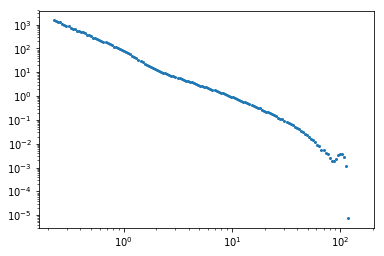

Computing correlation function on box 2


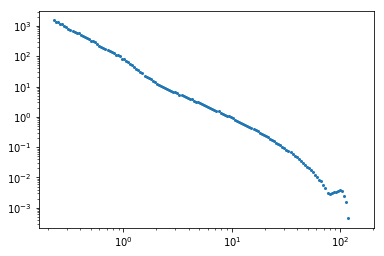

Computing correlation function on box 3


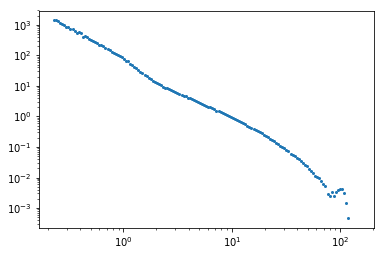

Computing correlation function on box 4


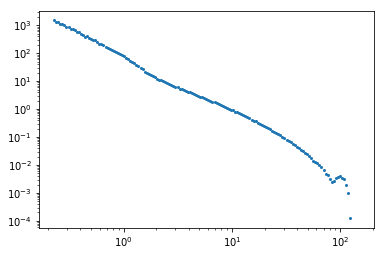

Computing correlation function on box 5


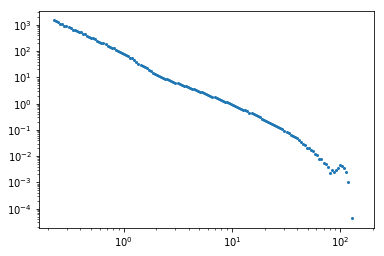

Computing correlation function on box 6


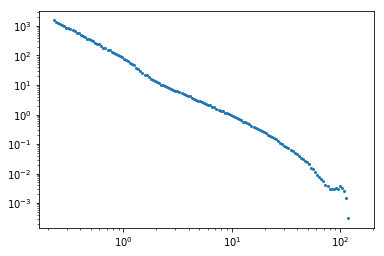

Computing correlation function on box 7


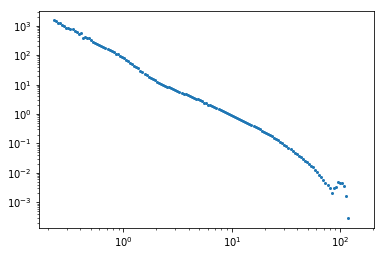

Computing correlation function on box 8


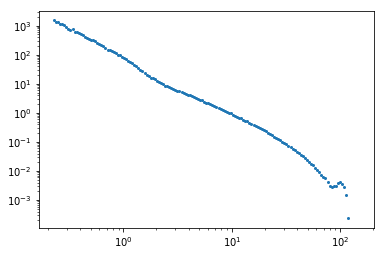

Computing correlation function on box 9


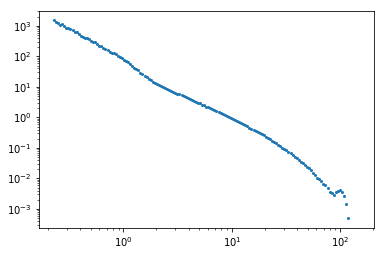

Computing correlation function on box 10


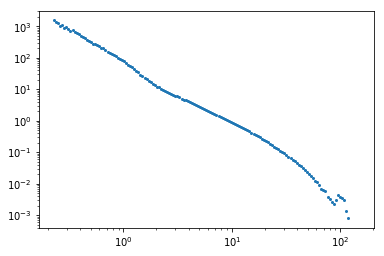

Computing correlation function on box 11


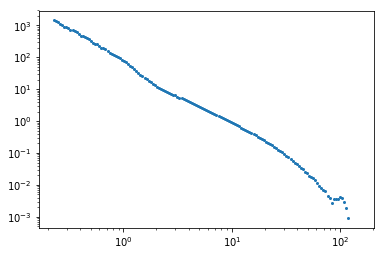

Computing correlation function on box 12


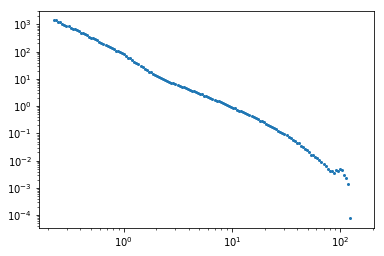

Computing correlation function on box 13


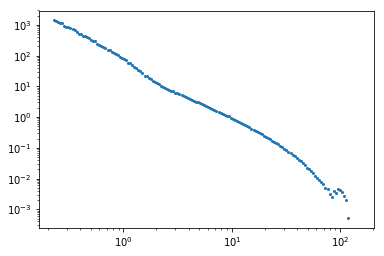

Computing correlation function on box 14


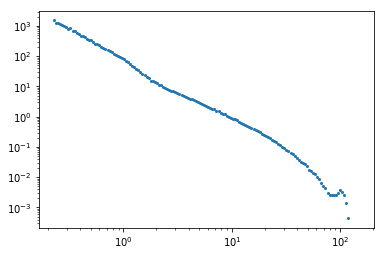

Computing correlation function on box 15


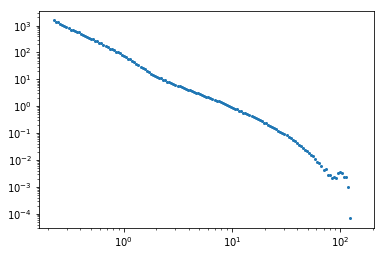

In [7]:
n_boxes = 15

for box in range(1, n_boxes+1):

    print(f'Computing correlation function on box {box}')
    r_bins_c, real_tpcf = compute_real_tpcf(box, 11, r_bins, num_threads = 16)

    tp = {'r': r_bins_c, 'tpcf': real_tpcf}
    
    with open(f'/raid/c-cuesta/tpcfs/gals_real_tpcf_box{box}.pickle', 'wb') as fp:
        pickle.dump(tp, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    plt.loglog(tp['r'], tp['tpcf'], linestyle='', marker='o', markersize=2)
    #plt.xlim(0,2)
    plt.show()

In [10]:
def compute_redshift_tpcf(mode, box, r_bins, mu_bins = None, snapshot = 11,
                          nthreads = 16, 
                          los_direction=2, boxsize=2000.):

    filename = f'/raid/kobayashi/mock_2Gpc/Mcorr/R1{box:02d}_S{snapshot:03d}_rockstar_gal_2Gpc_Mcorr_nfwcm_wFoG'

    pos = np.fromfile(filename + '_pos.bin', dtype = np.float32)
    pos = np.reshape(pos, (-1, 3)) 

    vel = np.fromfile(filename + '_vel.bin', dtype = np.float32)
    vel = np.reshape(vel, (-1, 3)) 


    s_pos = pos.copy()
    
    s_pos[:, los_direction] += vel[:, los_direction]/100. # to Mpc/h

    s_pos[:, los_direction][s_pos[:, los_direction]  > boxsize] -= boxsize

    s_pos[:, los_direction][s_pos[:, los_direction]  < 0.] += boxsize

    # rp_pi_tpcf always los = z
    if(los_direction != 2): 
        s_pos_old = s_pos.copy()
        s_pos[:,2] = s_pos_old[:,los_direction]
        s_pos[:,los_direction] = s_pos_old[:,2]
    
    r_bins_c = 0.5*(r_bins[1:] + r_bins[:-1])


    if mode == 'pi_sigma':
        tpcf = rp_pi_tpcf(s_pos, r_bins, r_bins, period=boxsize,
                estimator=u'Landy-Szalay', num_threads=nthreads)
        
        return r_bins_c, tpcf
    
    elif mode == 's_mu':
        tpcf = s_mu_tpcf(s_pos, r_bins, mu_bins, period=boxsize,
                estimator=u'Landy-Szalay', num_threads=nthreads)
        
        mu_bins_c = 0.5 * (mu_bins[1:] + mu_bins[:-1])
        
        return r_bins_c, mu_bins_c, tpcf
    
    else:
        print("Mode not valid!")
        return None


In [11]:
r_bins = np.arange(0., 50., 1.)
r_bins[0] = 0.0001
n_boxes = 15
n_mu_bins = 120

for box in range(1, n_boxes+1):
    
    mu_bins = np.linspace(0.,1.,n_mu_bins)


    print(f'Computing redshift space correlation function on box {box}')
    r_bins_c, tpcf_pi_sigma = compute_redshift_tpcf('pi_sigma',
                                                    box, r_bins)
    r_bins_c, mu_bins_c, tpcf_s_mu = compute_redshift_tpcf('s_mu',
                                                box,
                                                r_bins, mu_bins)

    tp = {'r': r_bins_c, 'mu_bins': mu_bins_c,
          'pi_sigma': tpcf_pi_sigma,
          's_mu': tpcf_s_mu}
    
    with open(f'/raid/c-cuesta/tpcfs/gals_redshift_tpcf_box{box}.pickle',
              'wb') as fp:
        
        pickle.dump(tp, fp, protocol=pickle.HIGHEST_PROTOCOL)

Computing redshift space correlation function on box 1
Computing redshift space correlation function on box 2
Computing redshift space correlation function on box 3
Computing redshift space correlation function on box 4
Computing redshift space correlation function on box 5
Computing redshift space correlation function on box 6
Computing redshift space correlation function on box 7
Computing redshift space correlation function on box 8
Computing redshift space correlation function on box 9
Computing redshift space correlation function on box 10
Computing redshift space correlation function on box 11
Computing redshift space correlation function on box 12
Computing redshift space correlation function on box 13
Computing redshift space correlation function on box 14
Computing redshift space correlation function on box 15


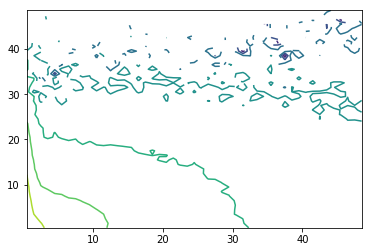

In [13]:
plt.contour(tp['r'], tp['r'], np.log10(tp['pi_sigma']).T)